In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as pyo

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS
from statsforecast.arima import arima_string
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
StatsForecast.save?

Signature:
StatsForecast.save(
    self,
    path: Union[pathlib.Path, str, NoneType] = None,
    max_size: Optional[str] = None,
    trim: bool = False,
)
Docstring:
Function that will save StatsForecast class with certain settings to make it
reproducible.

Parameters
----------
path : str or pathlib.Path, optional (default=None)
    Path of the file to be saved. If `None` will create one in the current
    directory using the current UTC timestamp.
max_size : str, optional (default = None)
    StatsForecast object should not exceed this size.
    Available byte naming: ['B', 'KB', 'MB', 'GB']
trim : bool (default = False)
    Delete any attributes not needed for inference.
File:      ~/.local/lib/python3.11/site-packages/statsforecast/core.py
Type:      function

In [4]:
class FixedARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecast = None
        self.plotting_df = pd.DataFrame()
        
        self.mae = None
        self.mse = None
        self.mape = None
        self.nmse = None
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_fixed_model(self, h, freq, season_length, model_name, level = []):
        if not self.sf:
            self.sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
            self.sf.fit(self.dfs[0])
            self.sf.save(path = f"AutoARIMA/fixed_models/{model_name}.pkl")
        
        start_date = datetime.strptime(self.dates[0], "%Y-%m-%d")
        ending_date = datetime.strptime(self.dates[-1], "%Y-%m-%d") + timedelta(weeks = h)

        prediction_horizon = abs((ending_date - start_date).days) // 7
        
        if not level:
            self.forecast = self.sf.predict(h = prediction_horizon)
        else:
            self.forecast = self.sf.predict(h = prediction_horizon, level = level)
            
        self.forecast.set_index("ds", inplace = True)
        self.forecast.drop(columns = "unique_id", inplace = True)
        
        
    def load_model(self, path):
        self.sf = StatsForecast.load(path = path)
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "AutoARIMA":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['AutoARIMA'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    def create_graph(self):
        if len(self.forecast.columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecast.columns)
    
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))
        
        for col in self.forecast.columns:
            if "hi" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         line = dict(color = self.color_mapping[number])))
                                         
        for col in self.forecast.columns:
            if "lo" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
        for col in self.forecast.columns:
            if col == "AutoARIMA":
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["AutoARIMA"])))
        
        fig.update_layout(title = f"Fixed Parameter ARIMA Predictions, {self.dates[0]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
        fig.show()
        
        
    def create_metrics(self):
        col_string = "AutoARIMA"
    
        self.mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.nmse = self.mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecast.index])

    def create_metrics_df(self):
        self.metrics_df.loc[len(self.metrics_df)] = [self.dates[0], self.mae, self.mse, self.mape, self.nmse]
    
    def create_display_df(self):
        for index, row in self.forecast.iterrows():
            reference_date = self.dates[0]
            target_end_date = index
            
            for col in self.forecast.columns:
                value = self.forecast.loc[target_end_date, col]
                if "lo" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = alpha / 2
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                if col == "AutoARIMA":
                    quantile = 0.5
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                elif "hi" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = 1 - (alpha / 2)
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
        
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [5]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [7]:
Processor = FixedARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [8]:
Processor.color_mapping

{}

In [9]:
Processor.create_training_dfs(value_col = "value")

In [10]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

Saving StatsForecast object of size 103.33KB.
StatsForecast object saved


In [11]:
Processor.forecast

,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,
2024-10-12,388.429862,-1976.537145,-1157.938945,1934.798670,2753.396869
2024-10-19,800.416312,-3978.064788,-2324.064537,3924.897161,5578.897411
2024-10-26,1079.562630,-5516.758116,-3233.539675,5392.664936,7675.883377
2024-11-02,1667.580132,-6348.980183,-3574.166912,6909.327176,9684.140447
2024-11-09,2570.686525,-6317.907225,-3241.252533,8382.625584,11459.280276
2024-11-16,3427.119749,-5974.720524,-2720.413173,9574.652671,12828.960022
2024-11-23,4408.338815,-5218.612740,-1886.386463,10703.064093,14035.290371
2024-11-30,6044.999399,-3662.042440,-302.094101,12392.092898,15752.041238
2024-12-07,7612.623031,-2105.967110,1257.978502,13967.267559,17331.213172


In [12]:
Processor.forecast.columns

Index(['AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-lo-80', 'AutoARIMA-hi-80',
       'AutoARIMA-hi-95'],
      dtype='object')

In [13]:
Processor.create_graph()

/tmp/ipykernel_24553/3721300032.py:64: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [14]:
Processor.forecast

,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,
2024-10-12,388.429862,-1976.537145,-1157.938945,1934.798670,2753.396869
2024-10-19,800.416312,-3978.064788,-2324.064537,3924.897161,5578.897411
2024-10-26,1079.562630,-5516.758116,-3233.539675,5392.664936,7675.883377
2024-11-02,1667.580132,-6348.980183,-3574.166912,6909.327176,9684.140447
2024-11-09,2570.686525,-6317.907225,-3241.252533,8382.625584,11459.280276
2024-11-16,3427.119749,-5974.720524,-2720.413173,9574.652671,12828.960022
2024-11-23,4408.338815,-5218.612740,-1886.386463,10703.064093,14035.290371
2024-11-30,6044.999399,-3662.042440,-302.094101,12392.092898,15752.041238
2024-12-07,7612.623031,-2105.967110,1257.978502,13967.267559,17331.213172


In [15]:
Processor.create_metrics()

In [16]:
Processor.create_metrics_df()

In [17]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,2573.067404,3.133529e+07,0.309506,0.240162


In [18]:
Processor.create_display_df()

In [19]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-1976.537145
2,2024-10-05,2024-10-12,0.100,-1157.938945
0,2024-10-05,2024-10-12,0.500,388.429862
3,2024-10-05,2024-10-12,0.900,1934.798670
4,2024-10-05,2024-10-12,0.975,2753.396869
...,...,...,...,...
61,2024-10-05,2025-01-04,0.025,9846.197174
62,2024-10-05,2025-01-04,0.100,13229.603099
60,2024-10-05,2025-01-04,0.500,19621.009034
63,2024-10-05,2025-01-04,0.900,26012.414968


In [20]:
Processor2 = FixedARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [21]:
Processor2.create_training_dfs(value_col = "value")

In [22]:
Processor2.load_model(path = "AutoARIMA/fixed_models/testing.pkl")

In [23]:
Processor2.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

In [24]:
Processor2.create_metrics()

In [25]:
Processor2.create_metrics_df()

In [26]:
Processor2.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,2573.067404,3.133529e+07,0.309506,0.240162


In [27]:
Processor2.forecast

,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,
2024-10-12,388.429862,-1976.537145,-1157.938945,1934.798670,2753.396869
2024-10-19,800.416312,-3978.064788,-2324.064537,3924.897161,5578.897411
2024-10-26,1079.562630,-5516.758116,-3233.539675,5392.664936,7675.883377
2024-11-02,1667.580132,-6348.980183,-3574.166912,6909.327176,9684.140447
2024-11-09,2570.686525,-6317.907225,-3241.252533,8382.625584,11459.280276
2024-11-16,3427.119749,-5974.720524,-2720.413173,9574.652671,12828.960022
2024-11-23,4408.338815,-5218.612740,-1886.386463,10703.064093,14035.290371
2024-11-30,6044.999399,-3662.042440,-302.094101,12392.092898,15752.041238
2024-12-07,7612.623031,-2105.967110,1257.978502,13967.267559,17331.213172


In [28]:
Processor.forecast

,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,
2024-10-12,388.429862,-1976.537145,-1157.938945,1934.798670,2753.396869
2024-10-19,800.416312,-3978.064788,-2324.064537,3924.897161,5578.897411
2024-10-26,1079.562630,-5516.758116,-3233.539675,5392.664936,7675.883377
2024-11-02,1667.580132,-6348.980183,-3574.166912,6909.327176,9684.140447
2024-11-09,2570.686525,-6317.907225,-3241.252533,8382.625584,11459.280276
2024-11-16,3427.119749,-5974.720524,-2720.413173,9574.652671,12828.960022
2024-11-23,4408.338815,-5218.612740,-1886.386463,10703.064093,14035.290371
2024-11-30,6044.999399,-3662.042440,-302.094101,12392.092898,15752.041238
2024-12-07,7612.623031,-2105.967110,1257.978502,13967.267559,17331.213172


In [29]:
Processor.forecast.equals(Processor2.forecast)

True

In [30]:
class UpdatingARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
            
    def create_models(self, h, freq, season_length, model_names, level = []):
        
        if not self.sfs:
            for i in range(len(self.dfs)):
                sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
                sf.fit(self.dfs[i])
                self.sfs.append(sf)
                sf.save(f"AutoARIMA/updating_models/{model_names[i]}.pkl")

      
        for i in range(len(self.dfs)):
            fc = pd.DataFrame()
            if not level:
                fc = self.sfs[i].predict(h = h)
            else:
                fc = self.sfs[i].predict(h = h, level = level)
            
            fc.set_index("ds", inplace = True)
            fc.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(fc)
    
    def load_models(self, paths):
        for i in range(len(paths)):
            sf = StatsForecast.load(path = paths[i])
            self.sfs.append(sf)
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "AutoARIMA":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['AutoARIMA'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    
    
    def create_graph(self):
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            for col in self.forecasts[i].columns:
                if col == "AutoARIMA":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["AutoARIMA"])))
                    
            fig.update_layout(title = f"Updating Parameter ARIMA Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
    def calculate_metrics(self):
        col_string = "AutoARIMA"
      
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoARIMA":
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [31]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [32]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [33]:
UProcessor = UpdatingARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [34]:
UProcessor.create_training_dfs(value_col = "value")

In [35]:
UProcessor.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

Saving StatsForecast object of size 103.33KB.
StatsForecast object saved
Saving StatsForecast object of size 103.40KB.
StatsForecast object saved
Saving StatsForecast object of size 103.46KB.
StatsForecast object saved
Saving StatsForecast object of size 103.52KB.
StatsForecast object saved
Saving StatsForecast object of size 103.62KB.
StatsForecast object saved


In [36]:
UProcessor.forecasts[4]

,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,
2024-12-14,9932.853747,7649.908144,8440.115853,11425.591641,12215.799349
2024-12-21,15685.958800,11117.181510,12698.595902,18673.321698,20254.736090
2024-12-28,22112.341784,15812.739415,17993.253198,26231.430370,28411.944152
2025-01-04,20046.880456,12401.161705,15047.613677,25046.147236,27692.599208


/tmp/ipykernel_24553/1161900276.py:67: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



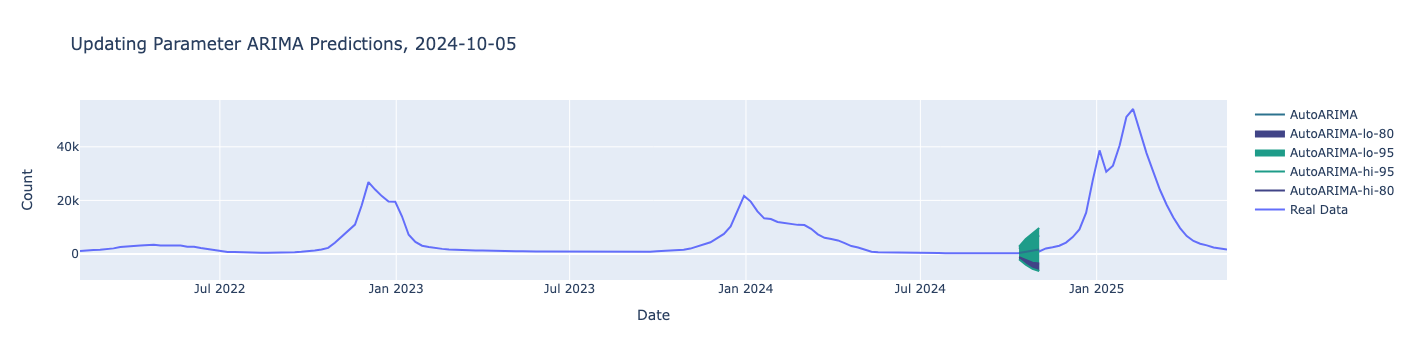

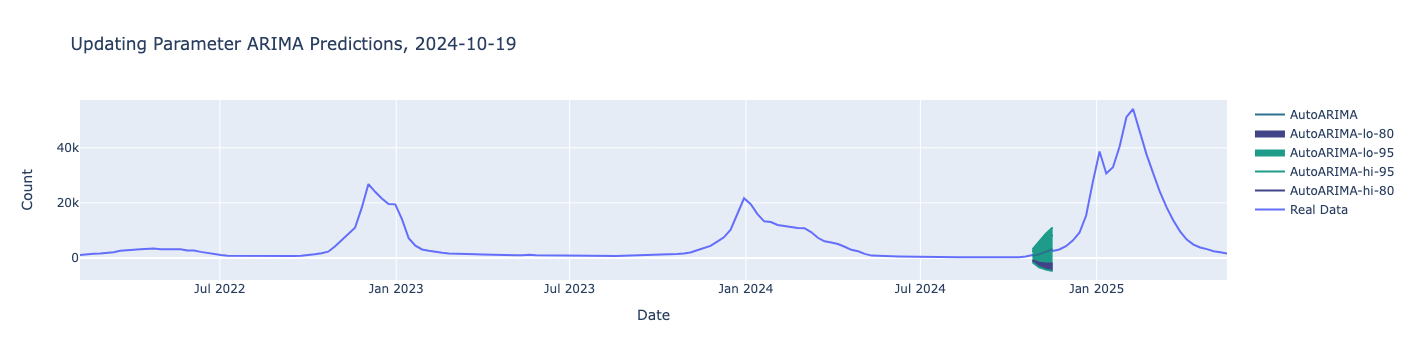

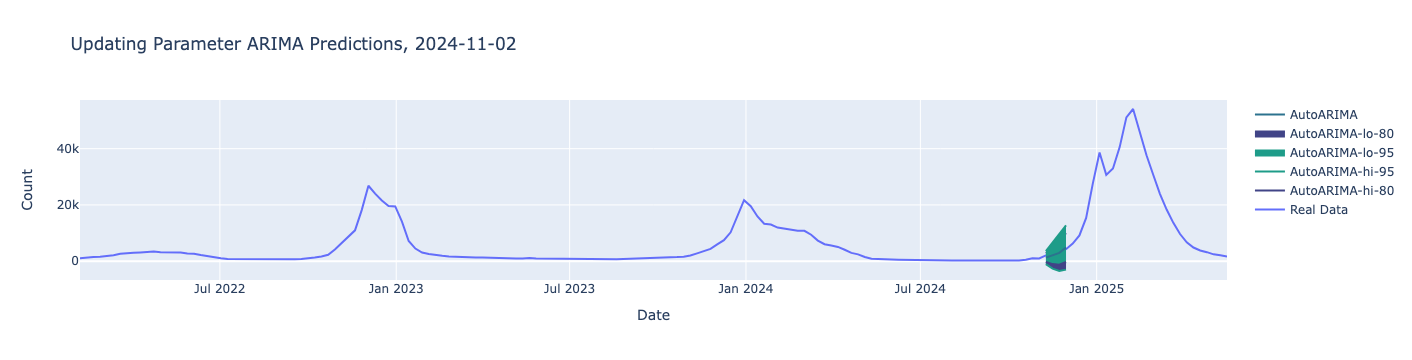

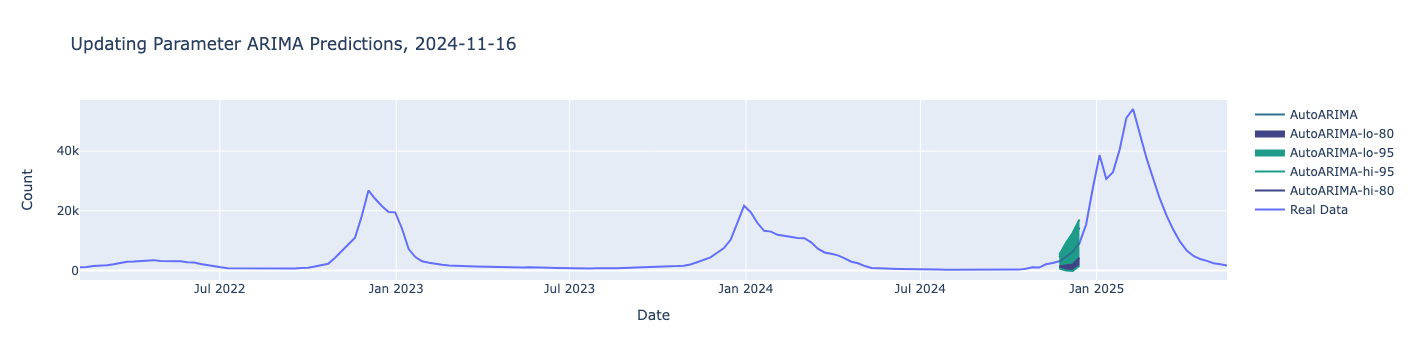

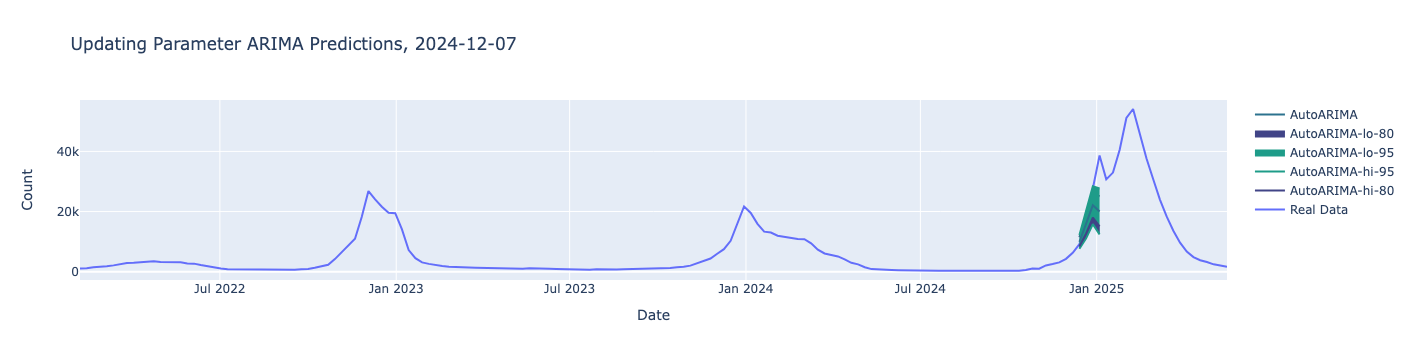

In [37]:
UProcessor.create_graph()

In [38]:
UProcessor.color_mapping

{'AutoARIMA': '#2c728e', '80': '#414487', '95': '#1e9c89'}

In [39]:
UProcessor.calculate_metrics()

In [40]:
UProcessor.create_metrics_df()

In [41]:
UProcessor.create_display_df()

In [42]:
UProcessor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,260.497234,1.378661e+05,0.377401,1.349297
1,2024-10-19,380.623630,1.729911e+05,0.253828,0.398847
2,2024-11-02,497.228155,3.096208e+05,0.188813,0.455890
3,2024-11-16,194.557516,5.292183e+04,0.041802,0.010033
4,2024-12-07,6307.897577,9.456597e+07,0.196470,0.732404


In [43]:
UProcessor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-1976.537145
2,2024-10-05,2024-10-12,0.100,-1157.938945
0,2024-10-05,2024-10-12,0.500,388.429862
3,2024-10-05,2024-10-12,0.900,1934.798670
4,2024-10-05,2024-10-12,0.975,2753.396869
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,12401.161705
97,2024-12-07,2025-01-04,0.100,15047.613677
95,2024-12-07,2025-01-04,0.500,20046.880456
98,2024-12-07,2025-01-04,0.900,25046.147236


In [44]:
UProcessor2 = UpdatingARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [45]:
UProcessor2.create_training_dfs(value_col="value")

In [46]:
model_paths = ["AutoARIMA/updating_models/test1.pkl", "AutoARIMA/updating_models/test2.pkl", "AutoARIMA/updating_models/test3.pkl", 
               "AutoARIMA/updating_models/test4.pkl", "AutoARIMA/updating_models/test5.pkl"]
UProcessor2.load_models(paths = model_paths)

In [47]:
UProcessor2.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

In [48]:
UProcessor2.create_display_df()

In [49]:
UProcessor2.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-1976.537145
2,2024-10-05,2024-10-12,0.100,-1157.938945
0,2024-10-05,2024-10-12,0.500,388.429862
3,2024-10-05,2024-10-12,0.900,1934.798670
4,2024-10-05,2024-10-12,0.975,2753.396869
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,12401.161705
97,2024-12-07,2025-01-04,0.100,15047.613677
95,2024-12-07,2025-01-04,0.500,20046.880456
98,2024-12-07,2025-01-04,0.900,25046.147236


In [50]:
UProcessor.display_df.equals(UProcessor2.display_df)

True